In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import requests
import os
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()  # reads the .env file automatically

True

In [20]:
import os, requests, pandas as pd

API_KEY = os.getenv("EIA_KEY")  # set first: export EIA_KEY="your_key"
BASE = "https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/"

COMMON = {
    "frequency": "daily",
    "data[0]": "value",
    "facets[respondent][]": "CAL",
    "facets[timezone][]": "Pacific",      # << your addition
    "start": "2019-01-01",
    "end":   "2025-09-27",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",         # keep your sort direction
    "length": 5000,
}

def fetch_all_daily():
    rows, offset, total = [], 0, None
    while True:
        params = COMMON.copy()
        params["api_key"] = API_KEY
        params["offset"]  = offset

        r = requests.get(BASE, params=params, timeout=60)
        r.raise_for_status()
        resp = r.json()["response"]

        if total is None:
            total = int(resp.get("total", 0))

        chunk = resp.get("data", [])
        rows.extend(chunk)
        print(f"Fetched {len(chunk):4d} rows @ offset {offset:,} "
              f"({len(rows):,}/{total:,})")

        if len(chunk) < params["length"] or offset + params["length"] >= total:
            break
        offset += params["length"]

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # Parse / clean
    # 'period' is daily like 'YYYY-MM-DD' (Pacific-local calendar day)
    df["period"] = pd.to_datetime(df["period"], format="%Y-%m-%d", errors="coerce")
    df["value"]  = pd.to_numeric(df["value"], errors="coerce")

    # Keep useful columns if present
    keep = ["period","respondent","respondent-name","fueltype","type-name",
            "timezone","value","value-units"]
    df = df[[c for c in keep if c in df.columns]].sort_values(["period","fueltype"])

    return df

if __name__ == "__main__":
    df_daily = fetch_all_daily()
    print("Daily shape:", df_daily.shape)
    if not df_daily.empty:
        df_daily.to_csv("eia_CAL_fueltype_daily_Pacific_2019_2025-09-27.csv", index=False)
        print(df_daily.head(10))

Fetched 5000 rows @ offset 0 (5,000/20,748)
Fetched 5000 rows @ offset 5,000 (10,000/20,748)
Fetched 5000 rows @ offset 10,000 (15,000/20,748)
Fetched 5000 rows @ offset 15,000 (20,000/20,748)
Fetched  748 rows @ offset 20,000 (20,748/20,748)
Daily shape: (20748, 8)
          period respondent respondent-name fueltype    type-name timezone  \
20740 2019-01-01        CAL      California      COL         Coal  Pacific   
20741 2019-01-01        CAL      California       NG  Natural Gas  Pacific   
20742 2019-01-01        CAL      California      NUC      Nuclear  Pacific   
20743 2019-01-01        CAL      California      OIL    Petroleum  Pacific   
20744 2019-01-01        CAL      California      OTH        Other  Pacific   
20745 2019-01-01        CAL      California      SUN        Solar  Pacific   
20746 2019-01-01        CAL      California      WAT        Hydro  Pacific   
20747 2019-01-01        CAL      California      WND         Wind  Pacific   
20732 2019-01-02        CAL    

In [21]:
df_daily.head()

,period,respondent,respondent-name,fueltype,type-name,timezone,value,value-units
20740,2019-01-01,CAL,California,COL,Coal,Pacific,36021,megawatthours
20741,2019-01-01,CAL,California,NG,Natural Gas,Pacific,199638,megawatthours
20742,2019-01-01,CAL,California,NUC,Nuclear,Pacific,54565,megawatthours
20743,2019-01-01,CAL,California,OIL,Petroleum,Pacific,2150,megawatthours
20744,2019-01-01,CAL,California,OTH,Other,Pacific,17823,megawatthours


In [22]:
df_daily.shape

(20748, 8)

In [7]:
def get_la_weather_data():
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 34.0522,
        "longitude": -118.2437,
        "start_date": "2019-01-01",
        "end_date": "2025-09-27",
        "daily": ["temperature_2m_mean", "precipitation_sum", "windspeed_10m_mean", 
                 "relative_humidity_2m_mean", "pressure_msl_mean"],
        "timezone": "America/Los_Angeles"
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'temperature_avg_c': data['daily']['temperature_2m_mean'],
        'precipitation_mm': data['daily']['precipitation_sum'],
        'wind_speed_kmh': data['daily']['windspeed_10m_mean'],
        'humidity_percent': data['daily']['relative_humidity_2m_mean'],
        'pressure_hpa': data['daily']['pressure_msl_mean']
    })
    
    return df

# Get the data
weather_data = get_la_weather_data()
print(weather_data.head())

        date  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
0 2019-01-01                8.4               0.0             9.5   
1 2019-01-02                8.9               0.0             5.4   
2 2019-01-03               11.3               0.0             5.6   
3 2019-01-04               12.2               0.0             6.6   
4 2019-01-05               11.1               8.0             9.0   

   humidity_percent  pressure_hpa  
0              23.0        1019.1  
1              20.0        1022.4  
2              30.0        1021.6  
3              37.0        1016.7  
4              77.0        1014.8  


In [8]:
weather_data.head()

,date,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
0,2019-01-01,8.4,0.0,9.5,23.0,1019.1
1,2019-01-02,8.9,0.0,5.4,20.0,1022.4
2,2019-01-03,11.3,0.0,5.6,30.0,1021.6
3,2019-01-04,12.2,0.0,6.6,37.0,1016.7
4,2019-01-05,11.1,8.0,9.0,77.0,1014.8


In [23]:
df_daily.dtypes

period             datetime64[ns]
respondent                 object
respondent-name            object
fueltype                   object
type-name                  object
timezone                   object
value                       int64
value-units                object
dtype: object

In [24]:
weather_data.dtypes

date                 datetime64[ns]
temperature_avg_c           float64
precipitation_mm            float64
wind_speed_kmh              float64
humidity_percent            float64
pressure_hpa                float64
dtype: object

In [25]:
df_daily.head()

,period,respondent,respondent-name,fueltype,type-name,timezone,value,value-units
20740,2019-01-01,CAL,California,COL,Coal,Pacific,36021,megawatthours
20741,2019-01-01,CAL,California,NG,Natural Gas,Pacific,199638,megawatthours
20742,2019-01-01,CAL,California,NUC,Nuclear,Pacific,54565,megawatthours
20743,2019-01-01,CAL,California,OIL,Petroleum,Pacific,2150,megawatthours
20744,2019-01-01,CAL,California,OTH,Other,Pacific,17823,megawatthours


In [26]:
# Sum values across all fuel types per day
daily_total = (
    df_daily.groupby("period", as_index=False)["value"]
            .sum()
            .rename(columns={"value": "total_value"})
)

# Now daily_total has only 'period' and 'total_value' columns
print(daily_total.head())

      period  total_value
0 2019-01-01       465701
1 2019-01-02       488901
2 2019-01-03       484062
3 2019-01-04       477305
4 2019-01-05       451001


In [27]:
daily_total.head()

,period,total_value
0,2019-01-01,465701
1,2019-01-02,488901
2,2019-01-03,484062
3,2019-01-04,477305
4,2019-01-05,451001


In [28]:
daily_total.shape

(2462, 2)

In [29]:
df_merged = pd.merge(daily_total, weather_data, left_on='period', right_on='date', how='inner')

In [30]:
df_merged.shape

(2462, 8)

In [31]:
df_merged.head()

,period,total_value,date,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
0,2019-01-01,465701,2019-01-01,8.4,0.0,9.5,23.0,1019.1
1,2019-01-02,488901,2019-01-02,8.9,0.0,5.4,20.0,1022.4
2,2019-01-03,484062,2019-01-03,11.3,0.0,5.6,30.0,1021.6
3,2019-01-04,477305,2019-01-04,12.2,0.0,6.6,37.0,1016.7
4,2019-01-05,451001,2019-01-05,11.1,8.0,9.0,77.0,1014.8


In [32]:
df_merged.describe()

,period,total_value,date,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
count,2462,2462.000000,2462,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,2022-05-15 12:00:00,575890.448010,2022-05-15 12:00:00,17.542398,1.296138,7.915163,63.458130,1015.020976
min,2019-01-01 00:00:00,91499.000000,2019-01-01 00:00:00,6.300000,0.000000,1.500000,9.000000,1000.900000
25%,2020-09-07 06:00:00,488972.250000,2020-09-07 06:00:00,13.600000,0.000000,6.400000,56.000000,1012.500000
50%,2022-05-15 12:00:00,560277.000000,2022-05-15 12:00:00,17.500000,0.000000,7.800000,68.000000,1014.500000
75%,2024-01-20 18:00:00,642445.500000,2024-01-20 18:00:00,21.300000,0.000000,9.000000,74.000000,1017.500000
max,2025-09-27 00:00:00,986686.000000,2025-09-27 00:00:00,34.400000,91.900000,26.900000,96.000000,1028.500000
std,NaN,119562.445548,NaN,4.780376,6.189210,2.551164,16.736344,3.715146


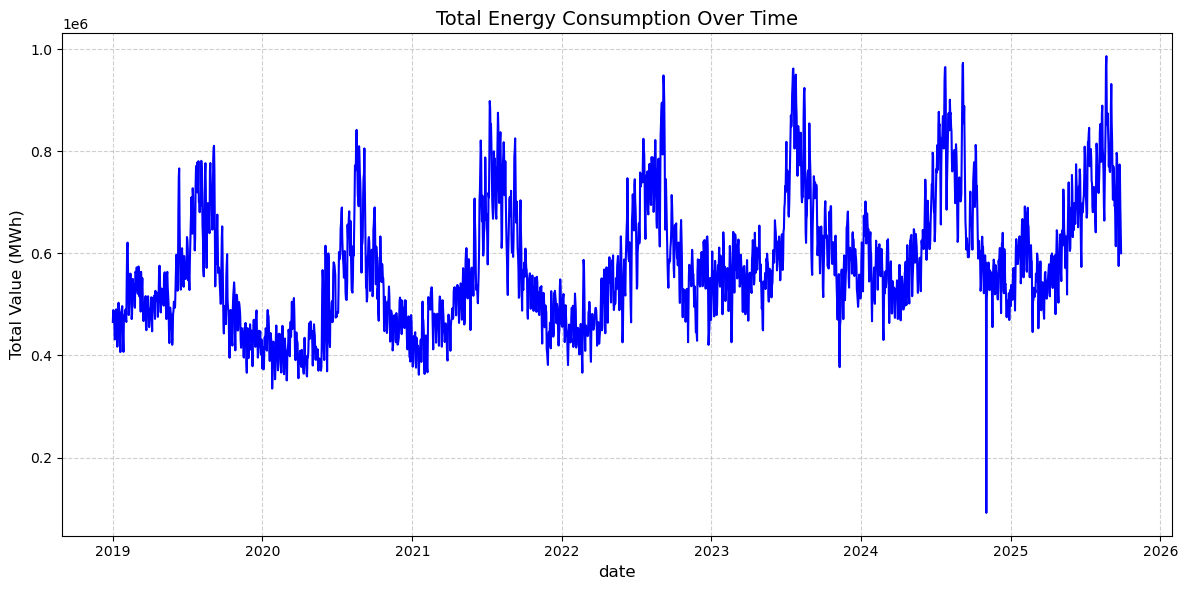

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(data=df_merged, x="date", y="total_value", color="blue")

plt.title("Total Energy Consumption Over Time", fontsize=14)
plt.xlabel("date", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

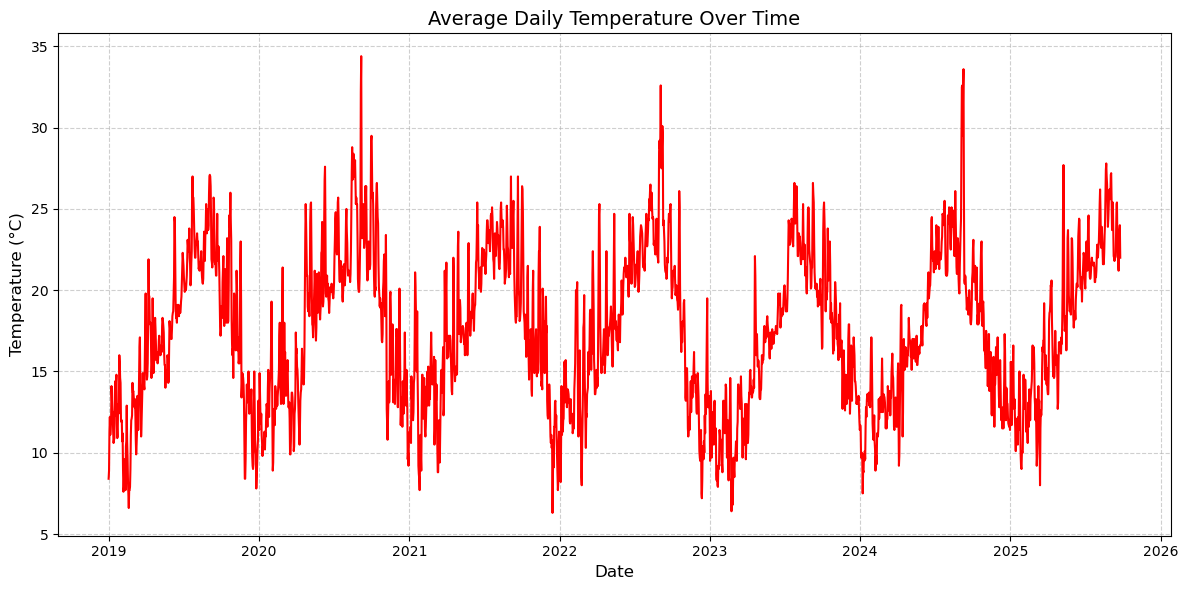

In [34]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_merged, x="date", y="temperature_avg_c", color="red")

plt.title("Average Daily Temperature Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

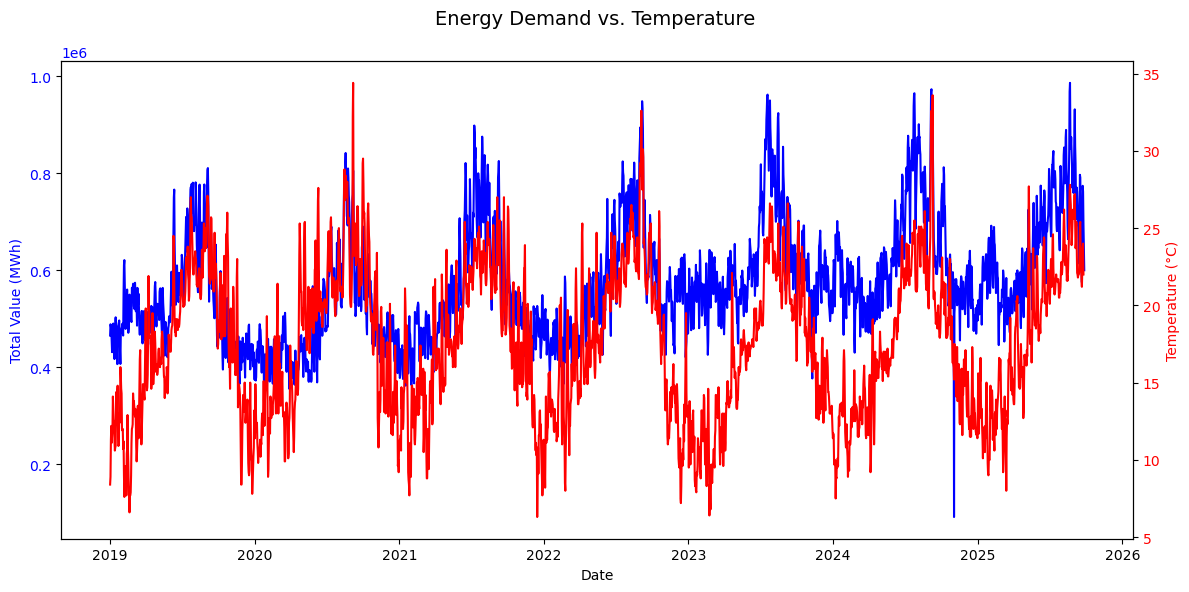

In [35]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot total energy
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Value (MWh)", color="blue")
ax1.plot(df_merged["date"], df_merged["total_value"], color="blue", label="Total Value")
ax1.tick_params(axis="y", labelcolor="blue")

# Twin axis for temperature
ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (°C)", color="red")
ax2.plot(df_merged["date"], df_merged["temperature_avg_c"], color="red", label="Temperature")
ax2.tick_params(axis="y", labelcolor="red")

fig.suptitle("Energy Demand vs. Temperature", fontsize=14)
fig.tight_layout()
plt.show()

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_35642/3981550314.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


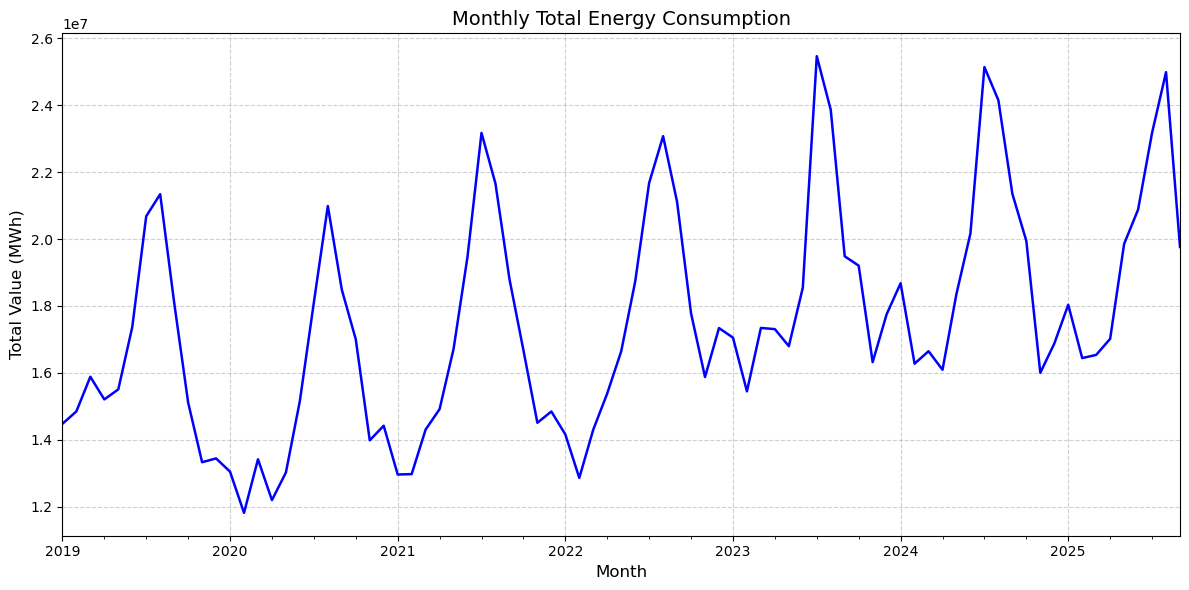

In [36]:
# Resample by month and sum values
monthly_total = (
    df_merged.set_index("date")["total_value"]
             .resample("M")
             .sum()
)

# Plot
plt.figure(figsize=(12,6))
monthly_total.plot(kind="line", color="blue", linewidth=1.8)

plt.title("Monthly Total Energy Consumption", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

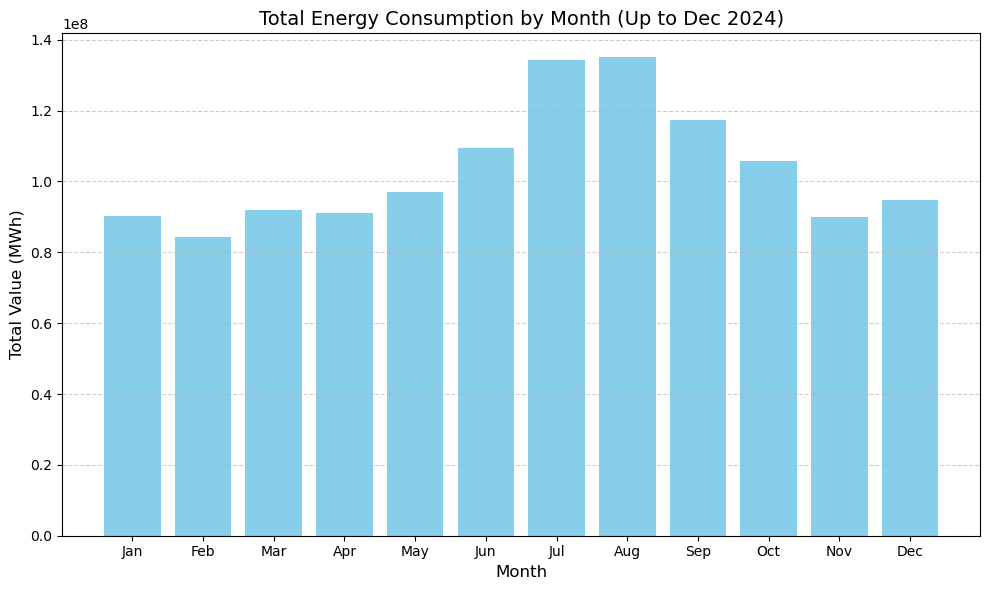

In [39]:
# Filter up to Dec 31, 2024
df_filtered = df_merged[df_merged["date"] <= "2024-12-31"]

# Group by month across all years
monthly_totals = (
    df_filtered.groupby(df_filtered["date"].dt.month)["total_value"]
               .sum()
)

# Month labels
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Plot
plt.figure(figsize=(10,6))
plt.bar(month_labels, monthly_totals, color="skyblue")

plt.title("Total Energy Consumption by Month (Up to Dec 2024)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

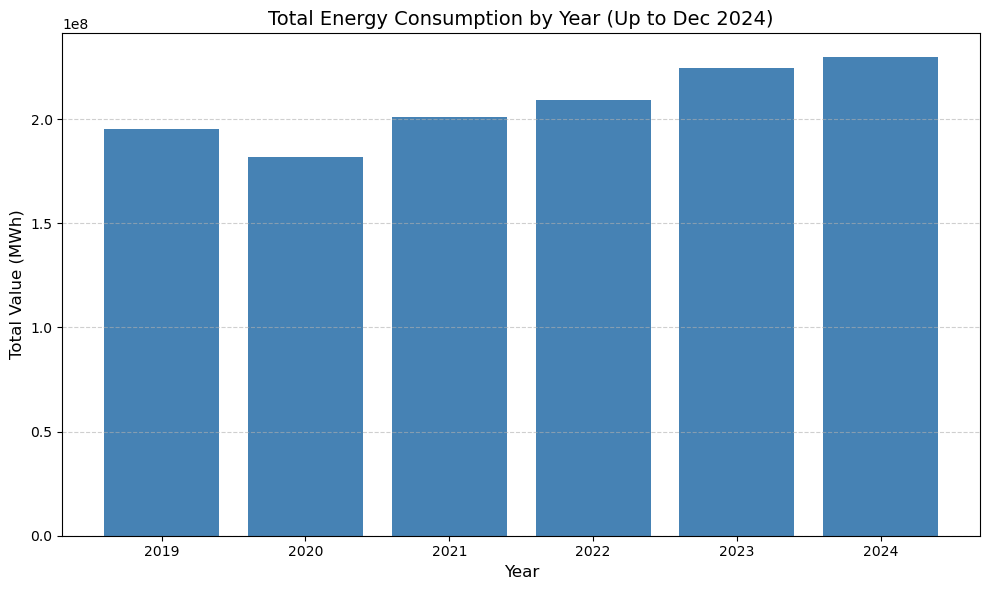

In [40]:
# Group by year
yearly_totals = (
    df_filtered.groupby(df_filtered["date"].dt.year)["total_value"]
               .sum()
)

# Plot
plt.figure(figsize=(10,6))
plt.bar(yearly_totals.index.astype(str), yearly_totals.values, color="steelblue")

plt.title("Total Energy Consumption by Year (Up to Dec 2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()